In [ ]:
import urllib.request
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import requests
import io
from PIL import Image


wd = webdriver.Chrome(ChromeDriverManager().install())


   


def get_image_from_unsplash(url,page_num):
    url_list=[]
    wd.get(url)
    time.sleep(1)
    i=1

    wd.execute_script("window.scrollTo(0, document.body.scrollHeight-1000);")
    wd.find_element_by_xpath('//*[@id="app"]/div/div[2]/div[4]/div[3]/div[1]/button').click()

    while(True):
        time.sleep(2)
        imageLinks=wd.find_elements_by_class_name('YVj9w')
        num_of_photos=len(url_list)
        for element in imageLinks:
            if element.get_attribute('src') in url_list:
                continue
            else:    
                url_list.append(element.get_attribute("src"))
        flag=len(url_list)
        if(flag==num_of_photos):#break loop ,didnt find new photos 
            break
        time.sleep(1)
        i+=1
        time.sleep(1)
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight-2000);")
        time.sleep(2)
        if(i==page_num):
            break
                
    return url_list




def download_image(download_path, url, file_name):
    try:
        image_cont = requests.get(url).content
        image_file = io.BytesIO(image_cont)
        image = Image.open(image_file)
        path = download_path + file_name

        with open(path, "wb") as f:
                image.save(f, "JPEG")
    except Exception as e:
        print('FAILED', e)





u_list=get_image_from_unsplash("https://unsplash.com/s/photos/french-bulldog",90)
for i, url in enumerate(u_list):
    download_image("french bulldog/", url, str(i) + ".jpeg")

u_list=get_image_from_unsplash("https://unsplash.com/s/photos/golden-retriver",90)
for i, url in enumerate(u_list):
    download_image("golden retriver/", url, str(i) + ".jpeg")

u_list=get_image_from_unsplash("https://unsplash.com/s/photos/siberian-husky",90)
for i, url in enumerate(u_list):
    download_image("siberian husky/", url, str(i) + ".jpeg")
    
wd.quit()






====== WebDriver manager ======
Current google-chrome version is 103.0.5060
Get LATEST chromedriver version for 103.0.5060 google-chrome
There is no [mac64] chromedriver for browser 103.0.5060 in cache
Trying to download new driver from https://chromedriver.storage.googleapis.com/103.0.5060.53/chromedriver_mac64.zip


In [1]:
# Import libraries

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix , classification_report

In [2]:
# Configure the desired dataset to work with
# The dataset is stored on Google Drive and mounted within Google Collab

dataset_path = '/content/drive/MyDrive/dataset3'
dataset_train_path = os.path.join(dataset_path, 'train')
dataset_test_path = os.path.join(dataset_path, 'test')

In [3]:
# Define the dogs classes to train and test the model on

dog_classes = ['french_bulldog',
               'golden_retriever',
               'siberian_husky']

In [26]:
# Explore the dog images,
# Create a dataframe to present the number of samples we have

dog_classes_data = []

for dog_class in dog_classes:
  dog_class_train_path = os.path.join(dataset_train_path, dog_class)
  dog_class_test_path = os.path.join(dataset_test_path, dog_class)

  dog_class_train_samples_count = len(os.listdir(dog_class_train_path))  
  dog_class_test_samples_count = len(os.listdir(dog_class_test_path))
  dog_class_total_samples_count = dog_class_train_samples_count + dog_class_test_samples_count

  dog_class_data = [dog_class,
                    dog_class_train_samples_count,
                    dog_class_test_samples_count,
                    dog_class_total_samples_count]

  dog_classes_data.append(dog_class_data)

train_classes_samples_count_df = pd.DataFrame(dog_classes_data, columns= ['class_name',
                                                                          'dog_class_train_samples_count',
                                                                          'dog_class_test_samples_count',
                                                                          'dog_class_total_samples_count'
                                                                          ])
train_classes_samples_count_df

,class_name,dog_class_train_samples_count,dog_class_test_samples_count,dog_class_total_samples_count
0,french_bulldog,1400,349,1749
1,golden_retriever,639,160,799
2,siberian_husky,1518,379,1897


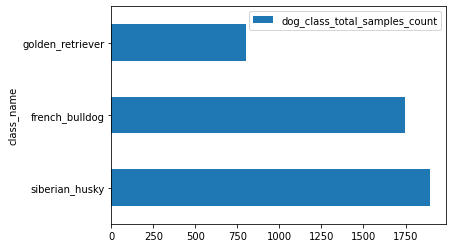

In [5]:
# Sort and plot the dataframe using the total images count of each class

train_classes_samples_count_df.sort_values('dog_class_total_samples_count', ascending= False, inplace= True)
ax = train_classes_samples_count_df.plot.barh(x= 'class_name', y= 'dog_class_total_samples_count', )

In [4]:
# Load the dataset from the Google Drive into memory
# Parse the images from jpeg binary format to a numeric 4D numpy array (X)
# Each image is resized to 224 * 224 pixels with RGB coloring
# For each img parsed we add the label of the img (y)


def load_selected_dataset(selected_dataset_path):
  dog_tensors = []
  dog_label_list = []

  for dog_class in dog_classes:
    print(f'working on {dog_class}')
    dog_class_path = os.path.join(selected_dataset_path, dog_class)
    dog_samples = os.listdir(dog_class_path)
    for dog_sample in dog_samples:
      try:
        dog_class_index = dog_classes.index(dog_class)
        dog_label_list.append([dog_class_index])

        dog_img_path = os.path.join(dog_class_path, dog_sample)
        dog_img = image.load_img(dog_img_path, target_size= (224,224))
        image_array_3D = image.img_to_array(dog_img)
        image_array_4D = np.expand_dims(image_array_3D, axis=0)

        dog_tensors.append(image_array_4D)
      except:
        print(f"problem in class: {dog_class} at picture: {dog_sample}")
        pass

  dog_label_array = np.array(dog_label_list)
  dog_tensors = np.vstack(dog_tensors)

  return dog_tensors, dog_label_array

In [5]:
# Load the train and test dataset with the above function

print("Loading train dataset")
X_train, y_train = load_selected_dataset(dataset_train_path)

print("Loading test dataset")
X_test, y_test = load_selected_dataset(dataset_test_path)


# the dataset contains color images, we need to normalize the RGB numbers

X_train = X_train / 255
X_test = X_test / 255

Loading train dataset
working on french_bulldog
working on golden_retriever
working on siberian_husky
Loading test dataset
working on french_bulldog
working on golden_retriever
working on siberian_husky


In [7]:
# Exploring the numpy array
# The 4D numpy array contains an array of images
# Each images is presented by 224X224 pixels
# Each pixel has 3 colors (Red, Blue, Green)

# Check the train dataset, 3557 images
# The model featrue is the image pixels, meaing each images has 224*224*3 = 150,528 features !
# Total amount of data points to train: 150,528 * 3557 = 535,428,096 data points

X_train.shape

(3557, 224, 224, 3)

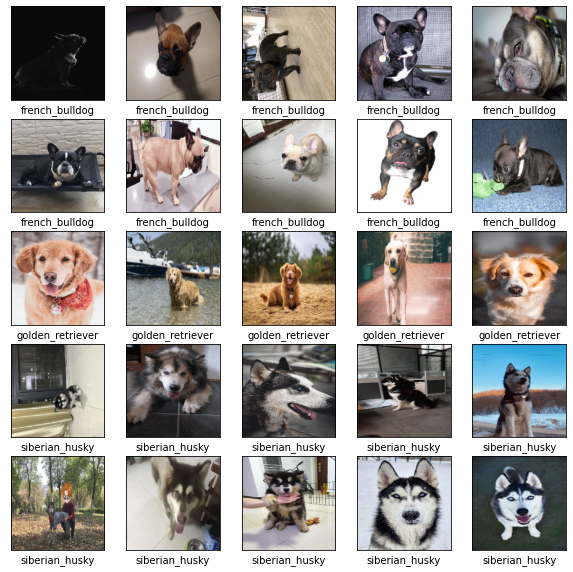

In [11]:
# Basic exploration of the images on our train dataset

img_index = 0
end_index = len(X_train)
number_of_imgs = 25
step = int((end_index - img_index) / number_of_imgs)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[img_index])
    plt.xlabel(dog_classes[y_train[img_index][0]])
    img_index += step

plt.show()

In [6]:
# Training a CNN is an intensive CPU work, A lot of matrix multiplication
# To make the process faster we do the matrix work with a GPU that is much
# Faster then a CPU 
# Because we work on Google Collab, we are able to use GPU for free
# Next we check that the GPU is availble

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

In [7]:
# Define the CNN model, using the GPU
# The CNN model is defined from scratch, with default weights.
# Each convolotion layer is define via the number of filters, the kernel size and activation
# We use max pooling of 2,2
# Finnaly we flatten the matrix and dense it to our 3 dog classes

with tf.device('/device:GPU:0'):
  model = models.Sequential(
      [
      layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (224,224,3)),
      layers.MaxPooling2D((2,2)),
      
      layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
      layers.MaxPooling2D((2,2)),
       
      layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
      layers.MaxPooling2D((2,2)),
      
      layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'),
      layers.MaxPooling2D((2,2)),
      
      layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu'),
      layers.MaxPooling2D((2,2)),
       
      layers.Flatten(),
      layers.Dense(3, activation='softmax')
      ]
  )

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [8]:
# Configuring the CNN model hyper parameters

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the CNN model with our train dataset
# Using epochs=18 (Showing the train set to the model 18 times)
# Using Validation data to prevent from model overfitting

model.fit(X_train, y_train, epochs=18, validation_data=(X_test, y_test))

Epoch 1/18
112/112 [==============================] - 17s 47ms/step - loss: 1.0019 - accuracy: 0.4630 - val_loss: 0.9359 - val_accuracy: 0.5394
Epoch 2/18
112/112 [==============================] - 4s 37ms/step - loss: 0.8564 - accuracy: 0.5758 - val_loss: 0.8470 - val_accuracy: 0.6047
Epoch 3/18
112/112 [==============================] - 4s 37ms/step - loss: 0.7724 - accuracy: 0.6275 - val_loss: 0.9140 - val_accuracy: 0.6171
Epoch 4/18
112/112 [==============================] - 4s 37ms/step - loss: 0.7101 - accuracy: 0.6714 - val_loss: 0.7128 - val_accuracy: 0.6869
Epoch 5/18
112/112 [==============================] - 4s 37ms/step - loss: 0.6047 - accuracy: 0.7383 - val_loss: 0.7777 - val_accuracy: 0.6779
Epoch 6/18
112/112 [==============================] - 4s 37ms/step - loss: 0.5432 - accuracy: 0.7638 - val_loss: 0.6158 - val_accuracy: 0.7376
Epoch 7/18
112/112 [==============================] - 4s 37ms/step - loss: 0.4489 - accuracy: 0.8119 - val_loss: 0.5757 - val_accuracy: 0.753

In [10]:
# Evaluating the model, we have an accuracy of 0.783
# Meaning that on a given img the model has a 78.3 % of being correct
# Not bad ! if the model has no inteligence he will chose randomly -- 33.33 % of being correct

model.evaluate(X_test, y_test)

28/28 [==============================] - 1s 19ms/step - loss: 1.2047 - accuracy: 0.7838


[1.204734444618225, 0.7837837934494019]

In [11]:
# Use the model to predict classes on the test set.

y_test_predicted = model.predict(X_test)


# Each predicted img has 3 numbers
# The numbers present the match of the img to each class given by the CNN model 
# The highest score is the best match according to the CNN model

y_test_predicted[0]

array([1.0000000e+00, 5.8035666e-22, 1.0544670e-08], dtype=float32)

In [12]:
# For each predicted img take the highest score of the 3 classes
# That presents the model img classification

y_test_predicted_max = [np.argmax(element) for element in y_test_predicted]

In [13]:
# For each class we have the percision, recall, f1-score and support
# You can notice that the siberian husky is the class most accurate

print(classification_report(y_test, y_test_predicted_max, target_names=dog_classes))

                  precision    recall  f1-score   support

  french_bulldog       0.77      0.83      0.80       349
golden_retriever       0.72      0.70      0.71       160
  siberian_husky       0.82      0.78      0.80       379

        accuracy                           0.78       888
       macro avg       0.77      0.77      0.77       888
    weighted avg       0.78      0.78      0.78       888



In [14]:
# A function to evalutate a given img from the test dataset
# Each img is plotted with the information of it class and the predicted class
# If the predicted class equals to the true class the model is correct
# Otherwise the model is wrong. Also print the img match score of each class

def evaluate_manually(sample_id):
  y_test_predicted_max_sample = y_test_predicted_max[sample_id]
  picture_pred_class = dog_classes[y_test_predicted_max_sample]
  plt.figure(figsize = (15,2))
  plt.imshow(X_test[sample_id])
  plt.xticks([])
  plt.yticks([])

  picture_class_index = y_test[sample_id][0]
  picture_class = dog_classes[picture_class_index]

  basic_label = f"real class: {picture_class}, predicted class: {picture_pred_class}, "
  if picture_class == picture_pred_class:
    picture_label = basic_label + "The model is correct !"
  else:
    sample_id_prediction = y_test_predicted[sample_id]
    classes_score = f"french_bulldog: {sample_id_prediction[0]}, golden_retriever: {sample_id_prediction[1]}, siberian_husky: {sample_id_prediction[2]}"
    picture_label = basic_label + "The model is wrong \n\n" + classes_score

  picture_label = picture_label + "\n\n\n\n"
  plt.xlabel(picture_label)


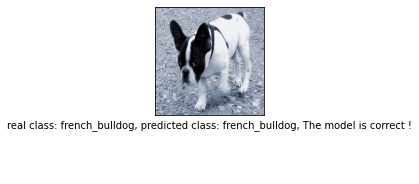

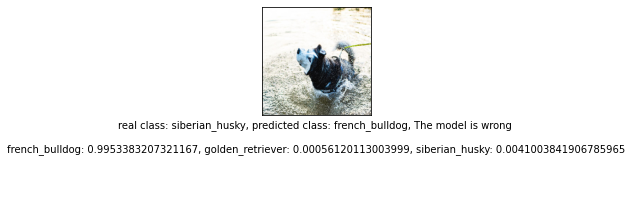

In [15]:
# The first img is of the french bulldog, the CNN model classified the img correctly.
# The second img is of husky, the CNN model miss-classified the img

evaluate_manually(301)
evaluate_manually(600)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


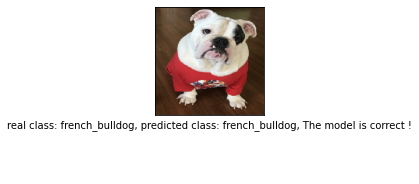

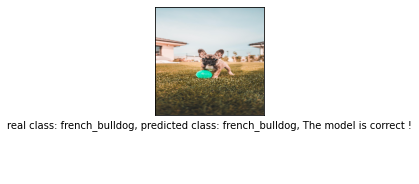

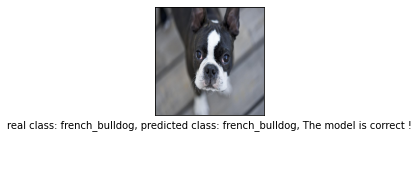

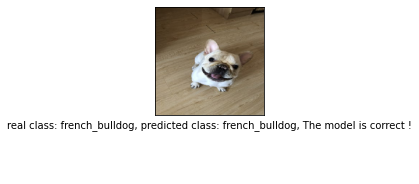

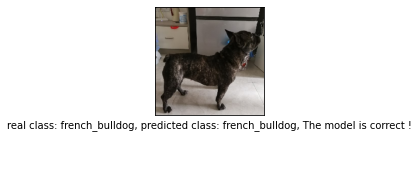

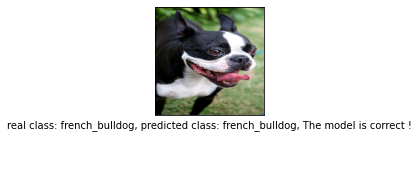

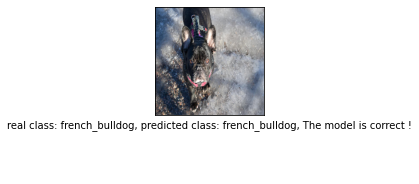

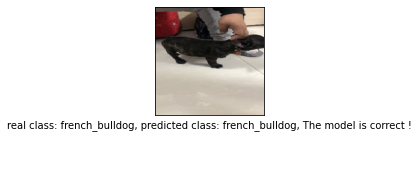

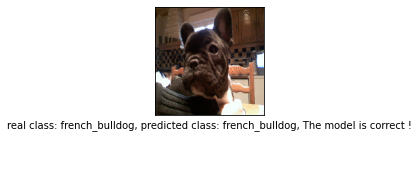

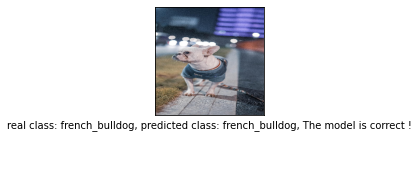

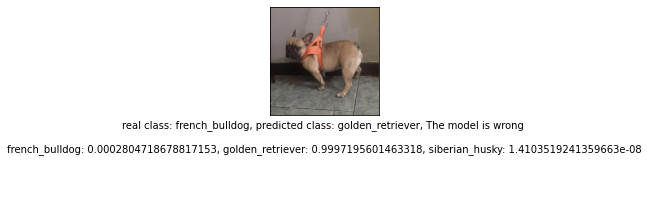

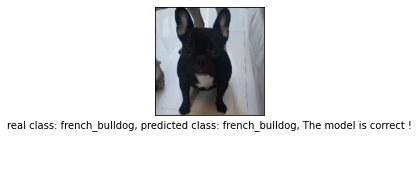

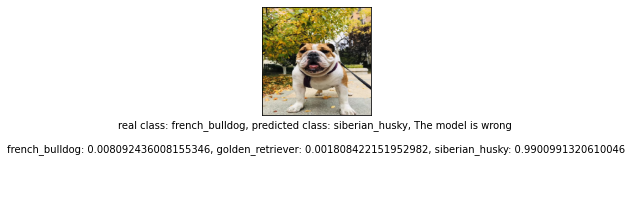

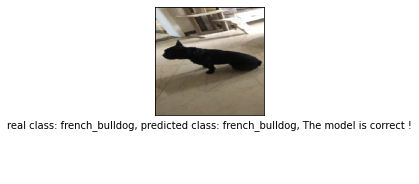

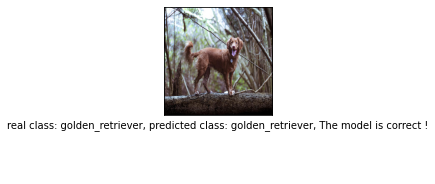

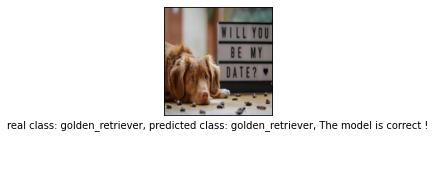

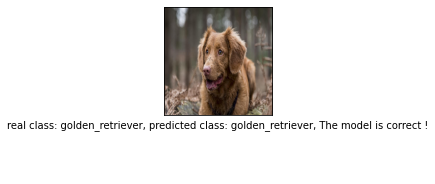

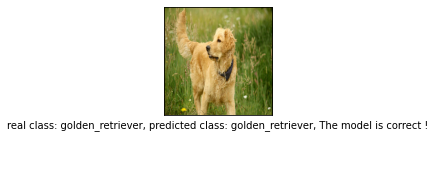

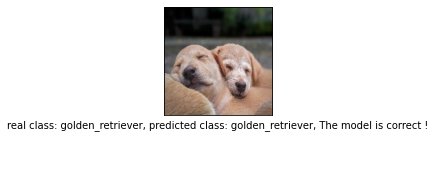

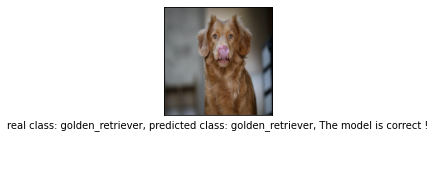

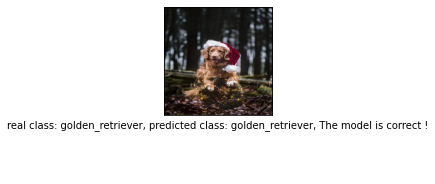

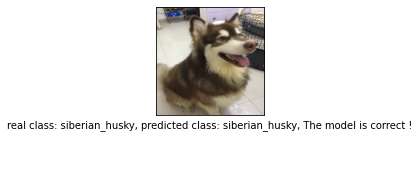

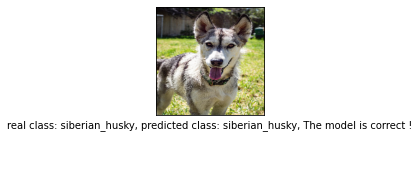

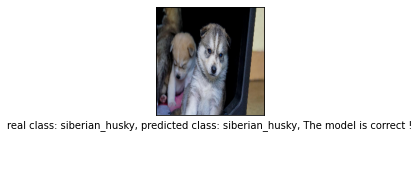

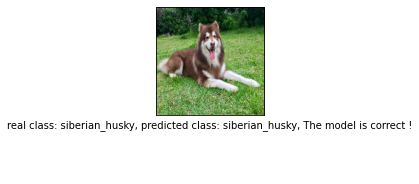

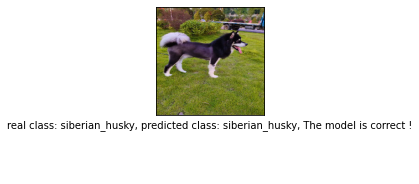

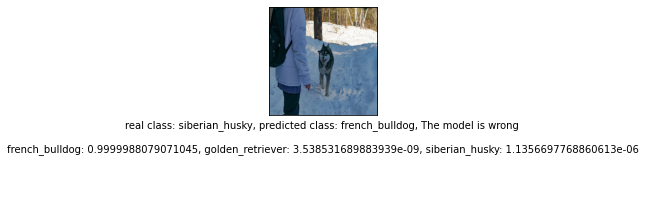

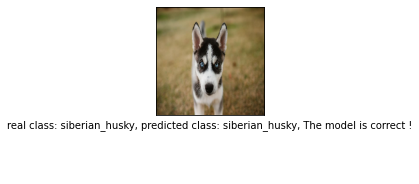

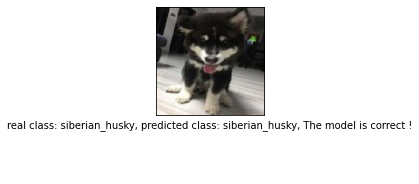

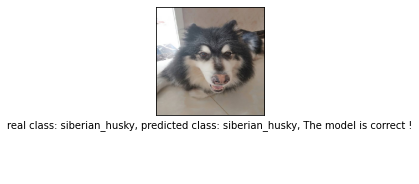

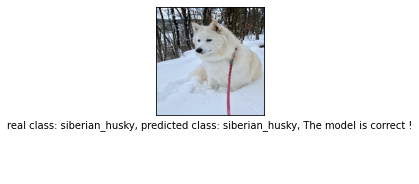

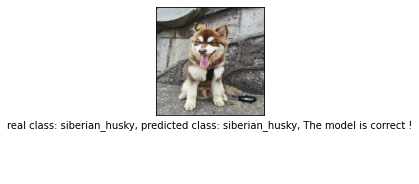

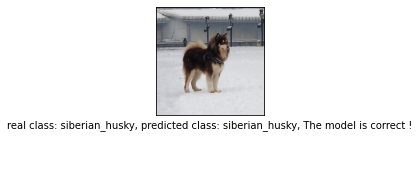

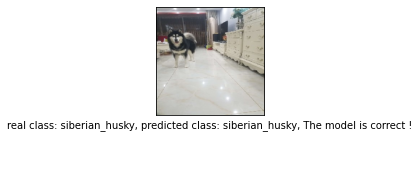

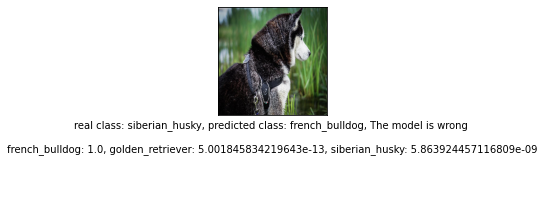

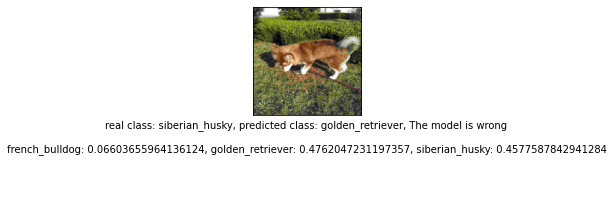

In [16]:
# Display random classified images from the test set
# Demonstrate that the model is working
# You can notice that the model is wrong sometimes
# Most of the times the model is wrong for a reason related to the img.

counter = 2
amount_of_test_samples = len(y_test)

while counter < amount_of_test_samples:
  evaluate_manually(counter)
  counter += 25